# Diffusion Models
---
Created by: [Alexander Cowen-Rivers](https://alexanderimanicowenrivers.github.io/), [Despoina Christou](https://www.linkedin.com/in/despoinachristou/)


<br>

 ### ✨✨Welcome to the **Diffusion Models** tutorial!✨✨

<br>


**👀Tutorial Overview**

In this tutorial we will be learning about Diffusion Models, a type of generative machine learning model.

<br>

**📜A little bit of history...**

The inception of diffusion models traces its origins back to 2015, influenced by insights from the field of non-equilibrium thermodynamics. The primary objective of diffusion models revolves around unraveling the underlying structure inherent in a dataset, achieved by encapsulating the manner in which data points spread out within the latent space. Particularly prominent in the domain of computer vision, this concept materializes as the **training of neural networks to rectify images distorted by Gaussian noise**.

<br>

**🤼Diffusion models VS other generative models like GANs and VAEs**

Diffusion models define a Markov chain of diffusion steps to slowly add random noise to data and then learn to reverse the diffusion process to construct desired data samples from the noise. Unlike VAE and GAN models, diffusion models are learned with a fixed procedure and the latent variable has high dimensionality (same as the original data).

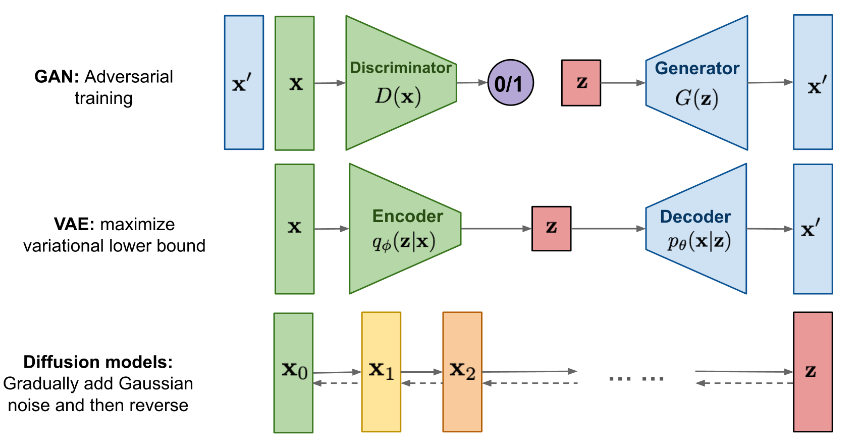



<br>

**👀Diffusion Models Overview**

In this tutorial we will be learning about `Diffusion Models`, a type of generative machine learning model. Also known as *diffusion probabilistic models* or *score-based generative models*, diffusers represent a specialized subset of **latent variable models**. Why?

Diffusers try to generate (usually) an image by trying to reconstruct a datum (image) by the original with added noise (Gaussian noise). This process is a **Markov chain** - i.e. a **system of transitions between different states**, where each state is an image with different amount of noise added. The **goal** of the diffusion model **is to learn the underlined latent variables** of the Markov chain.
By learning Gaussian transitions between states (images) we actually learn to reconstruct images from the noise so by repeating this operation multiple times we will be able to produce completely new images from the noise.


The diffusion process predominantly comprises three pivotal components:

1. the Forward process
2. the Reverse (backward) process, and
3. the Sampling protocol


<br>

**🧾Tutorial outline**
- Theory recap
- Setup
- Practical 1: Forward Diffusion Process - Introducing Noise Schedulers
- Practical 2: Backward Diffusion Process - Defining a model architecture
- Practical 3: Sampling - Inferring a new image



## Theory recap
---
<br>

# Forward diffusion process

Considering a data point drawn from a real data distribution, we can establish a forward diffusion process wherein we introduce minor Gaussian noise to the sampled image $x_0$ across successive $T$ stages. This generates a sequence of samples $x_1,...,x_T$  that exhibit varying degrees of noise. The magnitudes of these increments are regulated through a predefined schedule of variances.

<figure>
<img src=https://www.assemblyai.com/blog/content/images/size/w1000/2022/05/image.png style="width:100%">
<figcaption align = "center"> Taken from Ho, Jonathan, Ajay Jain, and Pieter Abbeel. "Denoising diffusion probabilistic models." Advances in neural information processing systems 33 (2020): 6840-6851.  </figcaption>
</figure>

The distinct characteristics of the data sample fade progressively as the size of each step increases. Ultimately, when the step size reaches a certain threshold, the sample's attributes converge to those of an Gaussian distribution.




With conditional distribution given by:

\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = {N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I})
\end{aligned}

This permits a factored distribution over multiple timesteps:

\begin{aligned}
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})
\end{aligned}

An advantageous aspect of the aforementioned procedure is that we can obtain samples at any chosen time step using a closed-form approach facilitated by the reparameterization trick. Let's denote: $\alpha_t = 1 - \beta_t$ and $\gamma_t = \prod_{i=1}^t \alpha_i$.

Using the re-parametrisation trick we can rewrite as follows:

\begin{aligned}
\mathbf{x}_t
&= \sqrt{\gamma_t}\mathbf{x}_0 + \sqrt{1 - \gamma_t}\boldsymbol{\epsilon}
\end{aligned}

Where: \begin{aligned}
\boldsymbol{\epsilon}_{t-1}, \boldsymbol{\epsilon}_{t-2}, \dots \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
\end{aligned}

Which can be formalised as:

\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= {N}(\mathbf{x}_t; \sqrt{\gamma_t} \mathbf{x}_0, (1 - \gamma_t)\mathbf{I})
\end{aligned}

<br>

# Backward diffusion process
<figure>
<img src=https://www.assemblyai.com/blog/content/images/size/w1000/2022/05/image-1.png style="width:100%">
<figcaption align = "center"> Taken from Ho, Jonathan, Ajay Jain, and Pieter Abbeel. "Denoising diffusion probabilistic models." Advances in neural information processing systems 33 (2020): 6840-6851.  </figcaption>
</figure>

<br>

**Target Distribution**:
\begin{aligned}
q(\mathbf{x}_{t-1} \vert \mathbf{x}_t) &= {N}(\mathbf{x}_{t-1}; \hat{\mu}_t (\mathbf{x}_t, \mathbf{x}_0), \hat\beta_t\mathbf{I})
\end{aligned}

Should we manage to invert the preceding process and draw samples from Z, it would enable us to reconstruct the original true sample by starting with a Gaussian noise input, ϵ. It's worth noting that if the variance of ϵ is sufficiently small, the resultant samples Z will also conform to a Gaussian distribution.

Unlike the forward process, we cannot use q(xₜ₋₁|xₜ) to reverse the noise since it is **intractable**.
Thus, to execute the reverse diffusion process, we must develop a model, $p_{\theta}$, to **approximate these conditional probabilities**.

Thus, we need to train a neural network pθ(xₜ₋₁|xₜ) to approximate q(xₜ₋₁|xₜ). The approximation pθ(xₜ₋₁|xₜ) follows a normal distribution and its mean and variance are set as follows:
\begin{aligned}
\mu_\theta(\mathbf{x}_{t}, t) = \hat{\mu}_t (\mathbf{x}_t, \mathbf{x}_0)
\end{aligned}
\begin{aligned}
Σ_\theta(\mathbf{x}_{t}, t) = \hat{\beta}_t\mathbf{I}
\end{aligned}

**Approximated Distribution**:
\begin{aligned}
p_{\theta}(\mathbf{x}_{t-1} \vert \mathbf{x}_t) &= {N}(\mathbf{x}_{t-1}; \hat{\mu}_θ (\mathbf{x}_t, t), Σ_\theta (\mathbf{x}_t, t))
\end{aligned}


## Setup
---

If you upload this to google colab, you should be able to run as is. Otherwise, installing packages in an enviroment will also work well! Make sure to connect to a TPU or GPU.

In [3]:
!pip install jax tensorflow-datasets flax

import jax
import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

import optax
import math

import os

import random as r
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import flax.linen as nn
from flax.training import train_state

from typing import Callable
from tqdm.notebook import tqdm
from PIL import Image
from IPython import display


# Set only 80% of memory to be accessible. This avoids OOM due to pre-allocation.
%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.8

# # Prevent TFDS from using TPU
# tf.config.experimental.set_visible_devices([], 'TPU')

# Defining some hyperparameters
NUM_EPOCHS = 10
BATCH_SIZE = 64
NUM_STEPS_PER_EPOCH = 60000//BATCH_SIZE

env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.8


In [4]:
jax.devices()

[gpu(id=0)]

In [5]:
# Load MNIST dataset and prepare training dataset
def prepare_mnist_dataset(batch_size):
  # Load the MNIST dataset
  train_ds = tfds.load('mnist', as_supervised=True, split="train")

  # Define a function for preprocessing
  def preprocess(x, y):
      # Resize, normalize, and scale the input images
      resized_image = tf.image.resize(tf.cast(x, tf.float32) / 127.5 - 1, (16, 16))
      return resized_image

  # Apply preprocessing, shuffle, batch, and prefetch
  train_ds = train_ds.map(preprocess, tf.data.AUTOTUNE)
  train_ds = train_ds.shuffle(5000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

  # Convert to numpy arrays for iteration
  train_ds_numpy = tfds.as_numpy(train_ds)

  return train_ds_numpy

train_ds = prepare_mnist_dataset(BATCH_SIZE)

## Practical 1: Forward Diffusion Process - Introducing Noise Schedulers
---

This practical exercise focuses on understanding and implementing noise schedulers. The primary objective is to create the forward process that introduces noise to images, thereby enabling the later transition from noisy to clean images.

Our aim is to achieve a predetermined level of expected noise at each sampling step, a concept referred to as the "noise schedule."

<br>

**The forward pass algorithm can be written as**:

1. Define the total timesteps $T$ for the chain
2. Generate $\beta, γ$ and $\hat\gamma$ for everty $t \in T$
3. Generate noise according to $$

<br>

### Defining a Noise Schedule

The noise schedule is a customizable parameter that we establish. We have the flexibility to subtract a consistent amount of noise at each step, or we can opt to subtract larger amounts at the initial steps. The sampler, at each step, effectively reduces the noise by the necessary amount to match the anticipated noise level in the subsequent step. This progression is clearly visible in the step-by-step illustration.

<br>



### Defining a Constant Value for Timesteps
We begin by defining a constant value timesteps which is set to 200. This value represents the number of time steps for the diffusion process.

<br>

#### Linear Beta Schedule Generation
The function `linear_beta_schedule` is designed to generate a beta schedule using linear interpolation. This schedule is crucial for controlling the diffusion process. Here's how it works:

1. Set the initial and final values for beta: beta_start = 0.0001 and beta_end = 0.02.
2. Generate linearly spaced values between beta_start and beta_end using jnp.linspace.
3. The resulting betas_schedule contains a sequence of beta values corresponding to different time steps.

##### Calculation of Alpha and Derivatives
The function `calculate_alpha_and_derivatives` calculates various values related to the diffusion process based on the given beta values. Here's the breakdown:

1. Calculate alpha from beta:
$\alpha = 1 - \text{beta}$

2. Calculate the cumulative product of alpha: This cumulative product
$\alpha_bar = \text{cumulative product}(\alpha)$

3. Adjust the alpha_bar array: To ensure the correct alignment with other arrays, a value of 1 is added to the beginning of the alpha_bar array.
$\text{alpha_bar} = \text{concatenate}([1.], \text{alpha_bar}[:-1])$

4. Calculate the square root of alpha_bar: This is denoted below and it's used in the diffusion process.
${\text{alpha_bar_sqrt}} = \text{sqrt}(\text{alpha_bar})$

5. Calculate the square root alphas, it's also utilized in the diffusion process.
${\text{one_minus_alpha_bar_sqrt}} = \text{sqrt}(1 - \text{alpha_bar})$

In summary, these calculations establish the fundamental parameters and derivatives necessary for simulating the diffusion process.

<br>

**WHAT TO IMPLEMENT**

[ 📝 ] Exercises [ 📝 ]

1. Implement a linear noise schedule (beginner)
2. Implement a cosine noise schedule (intermediate)
3. Implement another noise schedule from literature (advanced)
4. Implement a function that can take a noise schedule, and a noisy image, and compute the timestep at which this noised image was expected to be generated under that noise schedule. (advanced)

[ 🔎 ] Analysis [ 🔎 ]
1. Why do you think non-linear noise schedules help?
2. What is the model able to do in the low noise region that it cannot do in the high noise region?
3. Can you plot a linear vs non linear noise scheduler and make some comments about the differences over 1000 timesteps


### 📝Beginner

Implement a linear noise schedule

In [6]:
# Defining a constant value for timesteps
timesteps = 200

# Function to generate beta schedule using linear interpolation
def linear_beta_schedule(timesteps):
    """
    Generate a linear schedule for beta values.

    Args:
    - timesteps (int): The number of timesteps to generate beta values for.

    Returns:
    - list: A list of beta values linearly spaced between `beta_start` and `beta_end`.
    """
    beta_start = 0.0001
    beta_end = 0.02

    # Generate linearly spaced values between beta_start and beta_end
    betas_schedule = jnp.linspace(beta_start, beta_end, timesteps)
    return betas_schedule

def calculate_alpha_and_derivatives(beta):
    """
    Calculate alpha and its derivatives using the reparameterization trick.

    Args:
    - beta (array-like): An array of beta values.

    Returns:
    - tuple: A tuple containing the following values:
        - alpha (array-like): Computed alpha values.
        - alpha_bar (array-like): Cumulative product of alpha values.
        - sqrt_alpha_bar (array-like): Square root of alpha_bar.
        - one_minus_sqrt_alpha_bar (array-like): Square root of 1 - alpha_bar.
    """

    # Calculate alpha from beta
    alpha = 1 - beta

    # Calculate the cumulative product of alpha
    alpha_bar = jnp.cumprod(alpha, axis=0)

    # Adjust the alpha_bar array by prepending a 1 at the beginning
    alpha_bar = jnp.concatenate((jnp.array([1.]), alpha_bar[:-1]), axis=0)

    # Calculate the square root of alpha_bar
    sqrt_alpha_bar = jnp.sqrt(alpha_bar)

    # Calculate the square root of 1 - alpha_bar
    one_minus_sqrt_alpha_bar = jnp.sqrt(1 - alpha_bar)

    return alpha, alpha_bar, sqrt_alpha_bar, one_minus_sqrt_alpha_bar



def forward_noising(key, x_0, t, sqrt_alpha_bar, one_minus_sqrt_alpha_bar):
    """
    Apply noise to an input image using the reparameterization trick.

    Args:
    - key (array-like): Random key for noise generation.
    - x_0 (array-like): Initial input image.
    - t (int): Timestep for selecting alpha_bar values.
    - sqrt_alpha_bar (array-like): Square root of alpha_bar values.
    - one_minus_sqrt_alpha_bar (array-like): Square root of 1 - alpha_bar values.

    Returns:
    - tuple: A tuple containing the following values:
        - noisy_image (array-like): The noisy image after applying noise.
        - noise (array-like): Generated noise.
    """

    # Generate noise using a normal distribution
    noise = random.normal(key, x_0.shape)

    # Select the appropriate sqrt_alpha_bar and one_minus_sqrt_alpha_bar values for the given timestep t
    reshaped_sqrt_alpha_bar_t = jnp.reshape(jnp.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = jnp.reshape(jnp.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))

    # Calculate the noisy image using the reparameterization trick formula
    noisy_image = reshaped_sqrt_alpha_bar_t * x_0 + reshaped_one_minus_sqrt_alpha_bar_t * noise

    return noisy_image, noise

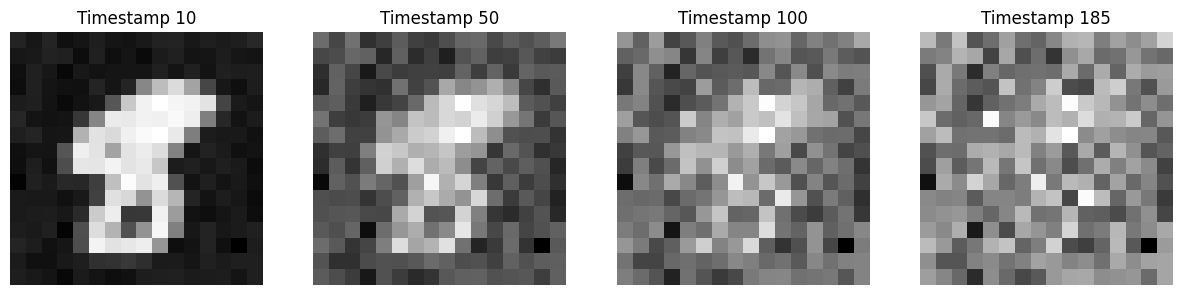

In [7]:
# Sample MNIST image
sample_mnist = next(iter(train_ds))[0]

# Create a figure to display the images
fig = plt.figure(figsize=(15, 30))

# Defining beta for all t's in T steps
# Using the functions with the provided timesteps value
beta = linear_beta_schedule(timesteps)

# Calculate alpha and derivates.
alpha, alpha_bar, sqrt_alpha_bar, one_minus_sqrt_alpha_bar = calculate_alpha_and_derivatives(beta)

# Iterate through the specified timesteps and visualize the images
for index, i in enumerate([10, 50, 100, 185]):
    # Generate noisy image and noise using forward_noising function
    noisy_im, noise = forward_noising(random.PRNGKey(0), jnp.expand_dims(sample_mnist, 0), jnp.array([i,]), sqrt_alpha_bar, one_minus_sqrt_alpha_bar)

    # Plot the noisy image
    plt.subplot(1, 4, index + 1)
    plt.imshow(jnp.squeeze(jnp.squeeze(noisy_im, -1), 0), cmap='gray')
    plt.title(f"Timestamp {i}")
    plt.axis('off')

# Show the figure with the visualized images
plt.show()

### 📝Intermediate

Implement a cosine noise schedule

In [8]:
# Function to generate beta schedule using sigmoid function
def sigmoid_beta_schedule(timesteps):
    """
    Generate a sigmoid-shaped schedule for beta values.

    Args:
    - timesteps (int): The number of timesteps to generate beta values for.

    Returns:
    - list: A list of beta values shaped by the sigmoid function and scaled between `beta_start` and `beta_end`.
    """

    # Set the initial and final values for beta
    beta_start = 0.0001
    beta_end = 0.02

    # Generate values from -6 to 6 uniformly distributed over timesteps
    betas = jnp.linspace(-6, 6, timesteps)

    # Apply the sigmoid function to the values and scale them to the desired range
    betas_schedule = jax.nn.sigmoid(betas) * (beta_end - beta_start) + beta_start

    return betas_schedule

# Function to generate beta schedule using cosine function
def cosine_beta_schedule(timesteps, s=0.008):
    """
    Generate a cosine-shaped schedule for beta values based on the paper: https://arxiv.org/abs/2102.09672

    Args:
    - timesteps (int): The number of timesteps to generate beta values for.
    - s (float): A smoothing parameter for the cosine schedule (default is 0.008).

    Returns:
    - list: A list of beta values following a cosine-shaped schedule.
    """

    # Calculate the total number of steps, including the initial step
    steps = timesteps + 1

    # Generate values from 0 to timesteps uniformly distributed over steps
    x = jnp.linspace(0, timesteps, steps)

    # Calculate cosine-based alphas cumulative product
    alphas_cumprod = jnp.cos(((x / timesteps) + s) / (1 + s) * jnp.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]

    # Calculate betas from alphas cumulative product
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])

    # Clip betas to ensure they are within the desired range
    betas_schedule = jnp.clip(betas, 0.0001, 0.9999)

    return betas_schedule

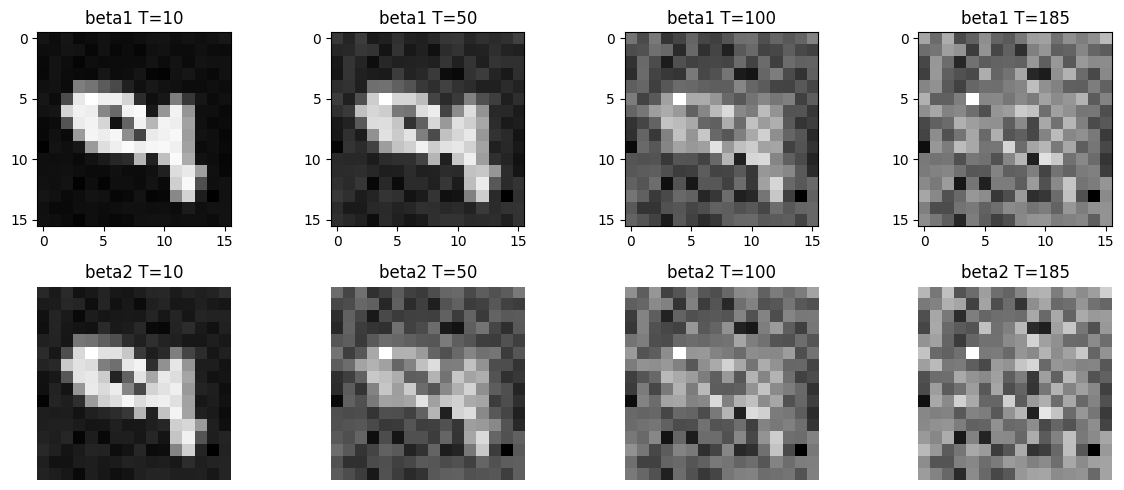

In [9]:
# Sample MNIST image
sample_mnist = next(iter(train_ds))[0]

# Create a figure to display the images
fig = plt.figure(figsize=(12, 5))

# Defining beta for all t's in T steps
# Using the functions with the provided timesteps value
beta1 = sigmoid_beta_schedule(timesteps)
beta2 = cosine_beta_schedule(timesteps)

# Calculate alpha and derivatives.
alpha1, alpha_bar2, sqrt_alpha_bar1, one_minus_sqrt_alpha_bar1 = calculate_alpha_and_derivatives(beta1)
alpha1, alpha_bar2, sqrt_alpha_bar2, one_minus_sqrt_alpha_bar2 = calculate_alpha_and_derivatives(beta2)

# Iterate through the specified timestamps and visualize the images
for index, i in enumerate([10, 50, 100, 185]):
    # Generate noisy image and noise using forward_noising function
    noisy_im1, noise1 = forward_noising(random.PRNGKey(0), jnp.expand_dims(sample_mnist, 0), jnp.array([i,]), sqrt_alpha_bar1, one_minus_sqrt_alpha_bar1)
    noisy_im2, noise2 = forward_noising(random.PRNGKey(0), jnp.expand_dims(sample_mnist, 0), jnp.array([i,]), sqrt_alpha_bar2, one_minus_sqrt_alpha_bar2)

    # Create a new row for each image
    plt.subplot(2, 4, index + 1)  # 2 rows, 4 columns
    plt.imshow(jnp.squeeze(jnp.squeeze(noisy_im1, -1), 0), cmap='gray')
    plt.title(f"beta1 T={i}")

    plt.subplot(2, 4, index + 5)  # Move to the second row
    plt.imshow(jnp.squeeze(jnp.squeeze(noisy_im2, -1), 0), cmap='gray')
    plt.title(f"beta2 T={i}")
    plt.axis('off')

# Show the figure with the visualized images
plt.tight_layout()
plt.show()

### 🔎Analysis


**1. Why do you think non-linear noise schedules help?**



Your answer:

**2. What is the model able to do in the low noise region that it cannot do in the high noise region?**

Your answer:








**3. Can you plot a linear vs non linear noise scheduler and make some comments about the differences over 1000 timesteps?**

In [10]:
# Plot

In [11]:
# Comments

## Practical 2. Backward Diffusion Process - Defining a model architecture
---
Scope:

This practical exercise focuses on understanding and implementing the reverse diffusion process, namely to reverse or remove the noise we added in the forward pass (Practical 1).
The primary objective is to define a Neural Network model that given a noisy image can predicts how the image resembled at a previous step by precisely predicting the added noise. <!-- Train a Neural Model that learns to remove noise from an image. Or getting an image, predicts the image in t-1 time. -->

For the backward denoising part, we can use any model with a large enough capacity.
Our aim is to define a model that best predicts the added noise.

### UNet Model

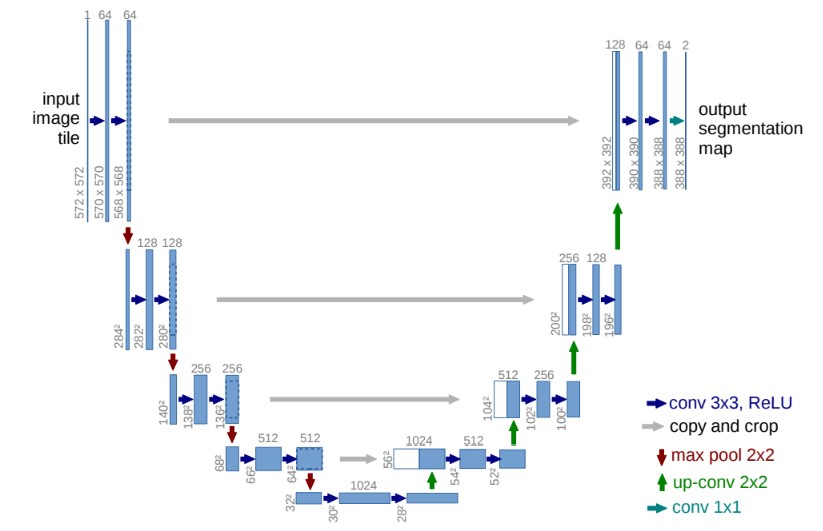

<br>

**Difference with Standard UNet**
![ModifiedUnet.jpg]()


The timestamp is first embedded into a N-dimensional vector and is then added to every layer in the model so that the model can learn the correlation between the noise and the timestamp and de-noise accordingly.

The training step performs the following functions:
1. Generate random PRNGKeys for generating the timestamps and noise
2. Generate the noisy images
3. Forward propagate on the UNet
4. Update the model weights in the backward propagation process according to the calculated gradients
5. Display loss at that particular step and return the current state and loss






WHAT TO IMPLEMENT

*(We do provide the training code in the "Helper Funtions". All you need to do is to create different types of NN models and analyze which one of them yields better results.)*

[ 📝 ] Exercises [ 📝 ]

1. Implement a UNet NN that does not take into account time embeddings (beginner)
2. Implement a UNet NN with time embeddings (intermediate)
3. Implement a UNet NN with time and label embeddings (advanced)


[ 🔎 ] Analysis [ 🔎 ]

1. Can you plot the time take for a forward pass of this network against dimension size?
2. Experiment with different dimension settings, whats most effective?
3. Experiment with different number of layers, whats most effective?
4. Tune hyperparms such as learning rate, can you find a better learning rate then the recommended 1e-4?
5. Can you plot the time take for a forward pass of this network against dimension size?
6. Experiment with different number of heads on MHA. What is the best setting?
7. Can you plot the loss over training steps.

### Helper Functions

In [12]:
# Calculate the gradients and loss values for the specific timestamp
@jax.jit
def apply_model(state, noisy_images, noise, timestamp):
    """
    Computes gradients and loss for a single batch.

    Args:
        state: Model state.
        noisy_images: Noisy input images.
        noise: Original noise.
        timestamp: Current timestamp.

    Returns:
        grads: Gradients of the loss with respect to model parameters.
        loss: Loss value calculated using Mean Squared Error.
    """
    def loss_fn(params):
        # Take the prediction from the model
        pred_noise = model.apply({'params': params}, [noisy_images, timestamp])

        # Calculate and return the MSE loss
        loss = jnp.mean((noise - pred_noise) ** 2)
        return loss

    # Calculate gradients w.r.t loss function and return the loss value and gradients
    grad_fn = jax.value_and_grad(loss_fn, has_aux=False)
    loss, grads = grad_fn(state.params)
    return grads, loss

# Helper function for applying the gradients to the model
@jax.jit
def update_model(state, grads):
    """
    Applies gradients to the model.

    Args:
        state: Model state.
        grads: Gradients of the loss with respect to model parameters.

    Returns:
        Updated model state.
    """
    return state.apply_gradients(grads=grads)

In [13]:
# Define the training step
def train_epoch(epoch_num, state, train_ds, batch_size, rng):
    epoch_loss = []

    # Loop through batches of images in the training dataset
    for index, batch_images in enumerate(tqdm(train_ds)):
        # Splitting the random number generator into two streams
        rng, tsrng = random.split(rng)

        # Generating timestamps for this batch
        timestamps = random.randint(tsrng,
                                    shape=(batch_images.shape[0],),
                                    minval=0, maxval=timesteps)

        # Generating the noise and noisy image for this batch
        noisy_images, noise = forward_noising(rng, batch_images, timestamps, sqrt_alpha_bar, one_minus_sqrt_alpha_bar)

        # Performing forward propagation through the model
        grads, loss = apply_model(state, noisy_images, noise, timestamps)

        # Updating the model using backpropagation
        state = update_model(state, grads)

        # Logging loss
        epoch_loss.append(loss)
        if index % 100 == 0:
            print(f"Loss at step {index}: ", loss)

        # Clearing unnecessary memory by deleting timestamps
        del timestamps

    # Calculating the mean loss for the epoch
    train_loss = np.mean(epoch_loss)

    # Returning the updated model state and the mean loss
    return state, train_loss

In [14]:
from flax.training import train_state

def create_train_state(rng):
    """Creates initial `TrainState`."""

    # Initializing model parameters using the init function from the 'model'
    params = model.init(rng, [jnp.ones([1, 16, 16, 1]), jnp.ones([1,])])['params']

    # Initializing the Adam optimizer with a learning rate of 1e-4
    tx = optax.adam(1e-4)

    # Creating a `TrainState` object by specifying the model apply function, parameters, and optimizer
    # This encapsulates the current state of training, including parameters and optimizer state
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [15]:
def train(train_ds) -> train_state.TrainState:
    # Create the master key for random number generation
    rng = jax.random.PRNGKey(0)

    # Split the master key into two subkeys: one for initialization and one for other uses
    rng, init_rng = jax.random.split(rng)

    # Create the initial training state using the initialization subkey
    state = create_train_state(init_rng)

    # Start training loop for multiple epochs
    for epoch in range(1, NUM_EPOCHS + 1):
        print("\nEPOCH: ", epoch)
        # Split the current random key to generate subkeys for various purposes
        rng, input_rng = jax.random.split(rng)

        # Call the train_epoch function to perform training for one epoch
        state, train_loss = train_epoch(epoch, state, train_ds, BATCH_SIZE, input_rng)

        # Print the training loss at the end of the epoch
        print(f"Training loss after epoch {epoch}: ", train_loss)

    # Return the final training state
    return state

### 📝Beginner

In [37]:
from flax import linen as nn
import jax.numpy as jnp
import math

class CosSinEmbedding(nn.Module):
    """
    A Flax module for computing sinusoidal embeddings (sine and cosine embeddings).

    This module takes an input and computes sinusoidal embeddings for it.

    Args:
        dim (int, optional): The dimension of the embedding. Defaults to 32.

    Returns:
        jnp.ndarray: The sinusoidal embeddings for the input.

    Example:
        # Create an instance of CosSinEmbedding
        embedding = CosSinEmbedding(dim=64)

        # Compute embeddings for an input tensor
        input_tensor = jnp.array([[1, 2, 3], [4, 5, 6]])
        embeddings = embedding(input_tensor)
    """

    # Initialize the dimension of the embedding
    dim: int = 32

    @nn.compact
    def __call__(self, inputs):
        """
        Compute the sinusoidal embeddings for the input tensor.

        Args:
            inputs (jnp.ndarray): The input tensor for which embeddings will be computed.

        Returns:
            jnp.ndarray: The sinusoidal embeddings for the input tensor.
        """

        # Calculate half of the dimension
        half_dim = self.dim // 2

        # Calculate the embedding coefficient
        emb = math.log(10000) / (half_dim - 1)

        # Calculate sinusoidal embeddings
        emb = jnp.exp(jnp.arange(half_dim) * -emb)
        emb = inputs[:, None] * emb[None, :]

        # Concatenate sine and cosine embeddings
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], -1)

        return emb

class TimeEmbedding(nn.Module):
    """
    A Flax module for computing time embeddings using sinusoidal embeddings.

    This module takes an input tensor and computes time embeddings by applying
    sinusoidal embeddings and projecting them into a higher dimensional space.

    Args:
        dim (int, optional): The dimension of the embedding. Defaults to 32.

    Returns:
        jnp.ndarray: The time embeddings for the input.

    Example:
        # Create an instance of TimeEmbedding
        time_embedding = TimeEmbedding(dim=64)

        # Compute time embeddings for an input tensor
        input_tensor = jnp.array([[1, 2, 3], [4, 5, 6]])
        time_embeddings = time_embedding(input_tensor)
    """

    # Initialize the dimension of the embedding
    dim: int = 32

    @nn.compact
    def __call__(self, inputs):
        """
        Compute the time embeddings for the input tensor.

        Args:
            inputs (jnp.ndarray): The input tensor for which time embeddings will be computed.

        Returns:
            jnp.ndarray: The time embeddings for the input tensor.
        """

        # Calculate the total dimension for time embedding
        time_dim = self.dim * 4

        # Apply CosSinEmbedding to generate sinusoidal embeddings
        se = CosSinEmbedding(self.dim)(inputs)

        # Project the embeddings into a higher dimensional space
        x = nn.Dense(time_dim)(se)
        x = nn.gelu(x)
        x = nn.Dense(time_dim)(x)

        return x

In [38]:
class MHAttention(nn.Module):
    # Initialize parameters
    dim: int
    num_heads: int = 8
    use_bias: bool = False
    kernel_init: Callable = nn.initializers.xavier_uniform()

    @nn.compact
    def __call__(self, inputs):
        # Reshape input tensor to a suitable format for attention computation
        batch, h, w, channels = inputs.shape
        inputs = inputs.reshape(batch, h * w, channels)
        batch, n, channels = inputs.shape

        # Calculate the scaling factor for attention
        scale = (self.dim // self.num_heads) ** -0.5

        # Apply Dense layer for q, k, v computation
        qkv = nn.Dense(self.dim * 3, use_bias=self.use_bias, kernel_init=self.kernel_init)(inputs)
        qkv = jnp.reshape(qkv, (batch, n, 3, self.num_heads, channels // self.num_heads))
        qkv = jnp.transpose(qkv, (2, 0, 3, 1, 4))
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Calculate attention scores and apply softmax
        attention = (q @ jnp.swapaxes(k, -2, -1)) * scale
        attention = nn.softmax(attention, axis=-1)

        # Calculate the attended values and reshape the output
        x = (attention @ v).swapaxes(1, 2).reshape(batch, n, channels)

        # Apply a Dense layer to transform the attended values
        x = nn.Dense(self.dim, kernel_init=nn.initializers.xavier_uniform())(x)
        x = jnp.reshape(x, (batch, int(x.shape[1] ** 0.5), int(x.shape[1] ** 0.5), -1))

        return x

In [39]:
class ConvBlock(nn.Module):
    # Initialize parameters
    dim: int = 32
    groups: int = 8

    @nn.compact
    def __call__(self, inputs):
        # Apply a convolutional layer
        conv = nn.Conv(self.dim, (3, 3))(inputs)

        # Apply group normalization
        norm = nn.GroupNorm(num_groups=self.groups)(conv)

        # Apply silu (swish) activation function
        activation = nn.silu(norm)
        return activation

class ResnetBlock(nn.Module):
    # Initialize parameters
    dim: int = 32
    groups: int = 8

    @nn.compact
    def __call__(self, inputs, time_embed=None):
        # Apply the ConvBlock to the input
        x = ConvBlock(self.dim, self.groups)(inputs)

        # If time embedding is provided, process it and add to the output
        if time_embed is not None:
            time_embed = nn.silu(time_embed)
            time_embed = nn.Dense(self.dim)(time_embed)
            time_embed = jnp.expand_dims(jnp.expand_dims(time_embed, 1), 1)
            x = time_embed + x

        # Apply the ConvBlock again to the modified input
        x = ConvBlock(self.dim, self.groups)(x)

        # Apply a 1x1 convolution to the input and add to the output
        res_conv = nn.Conv(self.dim, (1, 1), padding="SAME")(inputs)
        return x + res_conv

In [40]:
class UNet(nn.Module):
    # Initialize parameters
    dim: int = 8
    dim_scale_factor: tuple = (1, 2, 4, 8)
    num_groups: int = 8

    @nn.compact
    def __call__(self, inputs):
        # Separate input into image data and time embedding
        inputs, time = inputs

        # Extract the number of channels from the input
        channels = inputs.shape[-1]

        # Initial convolutional layer
        x = nn.Conv(self.dim // 3 * 2, (7, 7), padding=((3, 3), (3, 3)))(inputs)

        # Generate time embedding using TimeEmbedding
        time_emb = None#TimeEmbedding(self.dim)(time)

        # List to store pre-downsampling block outputs for residual connections
        pre_downsampling = []

        # Downsampling phase
        dims = [self.dim * i for i in self.dim_scale_factor]
        for index, dim in enumerate(dims):
            x = ResnetBlock(dim, self.num_groups)(x, time_emb)
            x = ResnetBlock(dim, self.num_groups)(x, time_emb)
            att = MHAttention(dim)(x)
            norm = nn.GroupNorm(self.num_groups)(att)
            x = norm + x

            # Save the output for residual connection with the upsampling layer
            pre_downsampling.append(x)

            if index != len(dims) - 1:
                x = nn.Conv(dim, (4, 4), (2, 2))(x)

        # Middle block
        x = ResnetBlock(dims[-1], self.num_groups)(x, time_emb)
        att = MHAttention(dim)(x)
        norm = nn.GroupNorm(self.num_groups)(att)
        x = norm + x
        x = ResnetBlock(dims[-1], self.num_groups)(x, time_emb)

        # Upsampling phase
        for index, dim in enumerate(reversed(dims)):
            x = jnp.concatenate([pre_downsampling.pop(), x], -1)
            x = ResnetBlock(dim, self.num_groups)(x, time_emb)
            x = ResnetBlock(dim, self.num_groups)(x, time_emb)
            att = MHAttention(dim)(x)
            norm = nn.GroupNorm(self.num_groups)(att)
            x = norm + x
            if index != len(dims) - 1:
                x = nn.ConvTranspose(dim, (4, 4), (2, 2))(x)

        # Final ResNet block and output convolutional layer
        x = ResnetBlock(dim, self.num_groups)(x, time_emb)
        x = nn.Conv(channels, (1, 1), padding="SAME")(x)
        return x

# Create an instance of the UNet model
model = UNet(32)

In [41]:
# Initiate Training
trained_state = train(train_ds)


EPOCH:  1


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  17.998432
Loss at step 100:  0.6312137
Loss at step 200:  0.48838076
Loss at step 300:  0.40094003
Loss at step 400:  0.37783903
Loss at step 500:  0.34956867
Loss at step 600:  0.37327427
Loss at step 700:  0.28728935
Loss at step 800:  0.34550488
Loss at step 900:  0.28392422
Training loss after epoch 1:  0.47220573

EPOCH:  2


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.28175586
Loss at step 100:  0.23916402
Loss at step 200:  0.18155673
Loss at step 300:  0.20444357
Loss at step 400:  0.21936712
Loss at step 500:  0.16453712
Loss at step 600:  0.22919777
Loss at step 700:  0.14555602
Loss at step 800:  0.16994792
Loss at step 900:  0.16224328
Training loss after epoch 2:  0.20405276

EPOCH:  3


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.1412903
Loss at step 100:  0.18478498
Loss at step 200:  0.16949566
Loss at step 300:  0.16081563
Loss at step 400:  0.14376059
Loss at step 500:  0.12075323
Loss at step 600:  0.13145792
Loss at step 700:  0.12685162
Loss at step 800:  0.15773508
Loss at step 900:  0.12895738
Training loss after epoch 3:  0.156376

EPOCH:  4


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.20788555
Loss at step 100:  0.12324847
Loss at step 200:  0.133019
Loss at step 300:  0.1877446
Loss at step 400:  0.19228032
Loss at step 500:  0.17971346
Loss at step 600:  0.120465755
Loss at step 700:  0.12358768
Loss at step 800:  0.15183416
Loss at step 900:  0.12337762
Training loss after epoch 4:  0.13786721

EPOCH:  5


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.11607577
Loss at step 100:  0.11249159
Loss at step 200:  0.16269243
Loss at step 300:  0.11413193
Loss at step 400:  0.13070086
Loss at step 500:  0.12240662
Loss at step 600:  0.12350259
Loss at step 700:  0.13387182
Loss at step 800:  0.09845355
Loss at step 900:  0.15616934
Training loss after epoch 5:  0.12664708

EPOCH:  6


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.14395368
Loss at step 100:  0.09320393
Loss at step 200:  0.13002387
Loss at step 300:  0.103225276
Loss at step 400:  0.12253479
Loss at step 500:  0.109018125
Loss at step 600:  0.104794204
Loss at step 700:  0.11974107
Loss at step 800:  0.123088114
Loss at step 900:  0.11139643
Training loss after epoch 6:  0.11992088

EPOCH:  7


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.12777203
Loss at step 100:  0.11268616
Loss at step 200:  0.113970414
Loss at step 300:  0.0931005
Loss at step 400:  0.1317052
Loss at step 500:  0.098609194
Loss at step 600:  0.11863954
Loss at step 700:  0.12064727
Loss at step 800:  0.093887106
Loss at step 900:  0.12968564
Training loss after epoch 7:  0.11485849

EPOCH:  8


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.09668276
Loss at step 100:  0.11264672
Loss at step 200:  0.10676636
Loss at step 300:  0.10658783
Loss at step 400:  0.08409203
Loss at step 500:  0.11596562
Loss at step 600:  0.12532696
Loss at step 700:  0.09995109
Loss at step 800:  0.12746114
Loss at step 900:  0.12138108
Training loss after epoch 8:  0.110175416

EPOCH:  9


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.1112536
Loss at step 100:  0.10080014
Loss at step 200:  0.11738868
Loss at step 300:  0.09615923
Loss at step 400:  0.12308444
Loss at step 500:  0.10797964
Loss at step 600:  0.10107589
Loss at step 700:  0.111427255
Loss at step 800:  0.11837289
Loss at step 900:  0.10352236
Training loss after epoch 9:  0.10729331

EPOCH:  10


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.10481317
Loss at step 100:  0.1071838
Loss at step 200:  0.09268089
Loss at step 300:  0.09853461
Loss at step 400:  0.092172325
Loss at step 500:  0.10194622
Loss at step 600:  0.10901923
Loss at step 700:  0.098365396
Loss at step 800:  0.10161422
Loss at step 900:  0.11800359
Training loss after epoch 10:  0.10376195


### 📝Intermediate

In [48]:
from flax import linen as nn
import jax.numpy as jnp
import math

class CosSinEmbedding(nn.Module):
    """
    A Flax module for computing sinusoidal embeddings (sine and cosine embeddings).

    This module takes an input and computes sinusoidal embeddings for it.

    Args:
        dim (int, optional): The dimension of the embedding. Defaults to 32.

    Returns:
        jnp.ndarray: The sinusoidal embeddings for the input.

    Example:
        # Create an instance of CosSinEmbedding
        embedding = CosSinEmbedding(dim=64)

        # Compute embeddings for an input tensor
        input_tensor = jnp.array([[1, 2, 3], [4, 5, 6]])
        embeddings = embedding(input_tensor)
    """

    # Initialize the dimension of the embedding
    dim: int = 32

    @nn.compact
    def __call__(self, inputs):
        """
        Compute the sinusoidal embeddings for the input tensor.

        Args:
            inputs (jnp.ndarray): The input tensor for which embeddings will be computed.

        Returns:
            jnp.ndarray: The sinusoidal embeddings for the input tensor.
        """

        # Calculate half of the dimension
        half_dim = self.dim // 2

        # Calculate the embedding coefficient
        emb = math.log(10000) / (half_dim - 1)

        # Calculate sinusoidal embeddings
        emb = jnp.exp(jnp.arange(half_dim) * -emb)
        emb = inputs[:, None] * emb[None, :]

        # Concatenate sine and cosine embeddings
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], -1)

        return emb

class TimeEmbedding(nn.Module):
    """
    A Flax module for computing time embeddings using sinusoidal embeddings.

    This module takes an input tensor and computes time embeddings by applying
    sinusoidal embeddings and projecting them into a higher dimensional space.

    Args:
        dim (int, optional): The dimension of the embedding. Defaults to 32.

    Returns:
        jnp.ndarray: The time embeddings for the input.

    Example:
        # Create an instance of TimeEmbedding
        time_embedding = TimeEmbedding(dim=64)

        # Compute time embeddings for an input tensor
        input_tensor = jnp.array([[1, 2, 3], [4, 5, 6]])
        time_embeddings = time_embedding(input_tensor)
    """

    # Initialize the dimension of the embedding
    dim: int = 32

    @nn.compact
    def __call__(self, inputs):
        """
        Compute the time embeddings for the input tensor.

        Args:
            inputs (jnp.ndarray): The input tensor for which time embeddings will be computed.

        Returns:
            jnp.ndarray: The time embeddings for the input tensor.
        """

        # Calculate the total dimension for time embedding
        time_dim = self.dim * 4

        # Apply CosSinEmbedding to generate sinusoidal embeddings
        se = CosSinEmbedding(self.dim)(inputs)

        # Project the embeddings into a higher dimensional space
        x = nn.Dense(time_dim)(se)
        x = nn.gelu(x)
        x = nn.Dense(time_dim)(x)

        return x

In [49]:
class MHAttention(nn.Module):
    # Initialize parameters
    dim: int
    num_heads: int = 8
    use_bias: bool = False
    kernel_init: Callable = nn.initializers.xavier_uniform()

    @nn.compact
    def __call__(self, inputs):
        # Reshape input tensor to a suitable format for attention computation
        batch, h, w, channels = inputs.shape
        inputs = inputs.reshape(batch, h * w, channels)
        batch, n, channels = inputs.shape

        # Calculate the scaling factor for attention
        scale = (self.dim // self.num_heads) ** -0.5

        # Apply Dense layer for q, k, v computation
        qkv = nn.Dense(self.dim * 3, use_bias=self.use_bias, kernel_init=self.kernel_init)(inputs)
        qkv = jnp.reshape(qkv, (batch, n, 3, self.num_heads, channels // self.num_heads))
        qkv = jnp.transpose(qkv, (2, 0, 3, 1, 4))
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Calculate attention scores and apply softmax
        attention = (q @ jnp.swapaxes(k, -2, -1)) * scale
        attention = nn.softmax(attention, axis=-1)

        # Calculate the attended values and reshape the output
        x = (attention @ v).swapaxes(1, 2).reshape(batch, n, channels)

        # Apply a Dense layer to transform the attended values
        x = nn.Dense(self.dim, kernel_init=nn.initializers.xavier_uniform())(x)
        x = jnp.reshape(x, (batch, int(x.shape[1] ** 0.5), int(x.shape[1] ** 0.5), -1))

        return x

In [50]:
class ConvBlock(nn.Module):
    # Initialize parameters
    dim: int = 32
    groups: int = 8

    @nn.compact
    def __call__(self, inputs):
        # Apply a convolutional layer
        conv = nn.Conv(self.dim, (3, 3))(inputs)

        # Apply group normalization
        norm = nn.GroupNorm(num_groups=self.groups)(conv)

        # Apply silu (swish) activation function
        activation = nn.silu(norm)
        return activation

class ResnetBlock(nn.Module):
    # Initialize parameters
    dim: int = 32
    groups: int = 8

    @nn.compact
    def __call__(self, inputs, time_embed=None):
        # Apply the ConvBlock to the input
        x = ConvBlock(self.dim, self.groups)(inputs)

        # If time embedding is provided, process it and add to the output
        if time_embed is not None:
            time_embed = nn.silu(time_embed)
            time_embed = nn.Dense(self.dim)(time_embed)
            time_embed = jnp.expand_dims(jnp.expand_dims(time_embed, 1), 1)
            x = time_embed + x

        # Apply the ConvBlock again to the modified input
        x = ConvBlock(self.dim, self.groups)(x)

        # Apply a 1x1 convolution to the input and add to the output
        res_conv = nn.Conv(self.dim, (1, 1), padding="SAME")(inputs)
        return x + res_conv

In [51]:
class UNet(nn.Module):
    # Initialize parameters
    dim: int = 8
    dim_scale_factor: tuple = (1, 2, 4, 8)
    num_groups: int = 8

    @nn.compact
    def __call__(self, inputs):
        # Separate input into image data and time embedding
        inputs, time = inputs

        # Extract the number of channels from the input
        channels = inputs.shape[-1]

        # Initial convolutional layer
        x = nn.Conv(self.dim // 3 * 2, (7, 7), padding=((3, 3), (3, 3)))(inputs)

        # Generate time embedding using TimeEmbedding
        time_emb = TimeEmbedding(self.dim)(time)

        # List to store pre-downsampling block outputs for residual connections
        pre_downsampling = []

        # Downsampling phase
        dims = [self.dim * i for i in self.dim_scale_factor]
        for index, dim in enumerate(dims):
            x = ResnetBlock(dim, self.num_groups)(x, time_emb)
            x = ResnetBlock(dim, self.num_groups)(x, time_emb)
            att = MHAttention(dim)(x)
            norm = nn.GroupNorm(self.num_groups)(att)
            x = norm + x

            # Save the output for residual connection with the upsampling layer
            pre_downsampling.append(x)

            if index != len(dims) - 1:
                x = nn.Conv(dim, (4, 4), (2, 2))(x)

        # Middle block
        x = ResnetBlock(dims[-1], self.num_groups)(x, time_emb)
        att = MHAttention(dim)(x)
        norm = nn.GroupNorm(self.num_groups)(att)
        x = norm + x
        x = ResnetBlock(dims[-1], self.num_groups)(x, time_emb)

        # Upsampling phase
        for index, dim in enumerate(reversed(dims)):
            x = jnp.concatenate([pre_downsampling.pop(), x], -1)
            x = ResnetBlock(dim, self.num_groups)(x, time_emb)
            x = ResnetBlock(dim, self.num_groups)(x, time_emb)
            att = MHAttention(dim)(x)
            norm = nn.GroupNorm(self.num_groups)(att)
            x = norm + x
            if index != len(dims) - 1:
                x = nn.ConvTranspose(dim, (4, 4), (2, 2))(x)

        # Final ResNet block and output convolutional layer
        x = ResnetBlock(dim, self.num_groups)(x, time_emb)
        x = nn.Conv(channels, (1, 1), padding="SAME")(x)
        return x

# Create an instance of the UNet model
model = UNet(32)

In [52]:
# Initiate Training
trained_state = train(train_ds)


EPOCH:  1


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  13.120215
Loss at step 100:  0.6024474
Loss at step 200:  0.4767106
Loss at step 300:  0.39904135
Loss at step 400:  0.35694897
Loss at step 500:  0.3436389
Loss at step 600:  0.34623235
Loss at step 700:  0.2572683
Loss at step 800:  0.28888172
Loss at step 900:  0.23042229
Training loss after epoch 1:  0.4409675

EPOCH:  2


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.23520544
Loss at step 100:  0.20131081
Loss at step 200:  0.16642816
Loss at step 300:  0.17759286
Loss at step 400:  0.18948875
Loss at step 500:  0.14151266
Loss at step 600:  0.20296009
Loss at step 700:  0.13216865
Loss at step 800:  0.15253326
Loss at step 900:  0.15207824
Training loss after epoch 2:  0.17848283

EPOCH:  3


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.13839594
Loss at step 100:  0.16605252
Loss at step 200:  0.14895126
Loss at step 300:  0.13719475
Loss at step 400:  0.1424859
Loss at step 500:  0.1101125
Loss at step 600:  0.12689328
Loss at step 700:  0.1160083
Loss at step 800:  0.14825103
Loss at step 900:  0.121590145
Training loss after epoch 3:  0.1426417

EPOCH:  4


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.19795442
Loss at step 100:  0.107736886
Loss at step 200:  0.12776959
Loss at step 300:  0.17272678
Loss at step 400:  0.17167893
Loss at step 500:  0.16418913
Loss at step 600:  0.10834634
Loss at step 700:  0.11139096
Loss at step 800:  0.14004532
Loss at step 900:  0.11195403
Training loss after epoch 4:  0.12650642

EPOCH:  5


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.10468655
Loss at step 100:  0.1073623
Loss at step 200:  0.14035189
Loss at step 300:  0.10770281
Loss at step 400:  0.11919339
Loss at step 500:  0.12041771
Loss at step 600:  0.114361346
Loss at step 700:  0.10551849
Loss at step 800:  0.100321546
Loss at step 900:  0.1398613
Training loss after epoch 5:  0.11735694

EPOCH:  6


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.13354813
Loss at step 100:  0.082984835
Loss at step 200:  0.114864066
Loss at step 300:  0.0943719
Loss at step 400:  0.11946565
Loss at step 500:  0.09931761
Loss at step 600:  0.10260884
Loss at step 700:  0.11063855
Loss at step 800:  0.119103074
Loss at step 900:  0.10554496
Training loss after epoch 6:  0.111117795

EPOCH:  7


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.124814376
Loss at step 100:  0.094211705
Loss at step 200:  0.10276955
Loss at step 300:  0.097407475
Loss at step 400:  0.11172443
Loss at step 500:  0.09385242
Loss at step 600:  0.10653627
Loss at step 700:  0.11039771
Loss at step 800:  0.092436016
Loss at step 900:  0.11284541
Training loss after epoch 7:  0.106761016

EPOCH:  8


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.10094604
Loss at step 100:  0.10661279
Loss at step 200:  0.10123329
Loss at step 300:  0.09460145
Loss at step 400:  0.090561934
Loss at step 500:  0.11628385
Loss at step 600:  0.1189517
Loss at step 700:  0.09302397
Loss at step 800:  0.122821465
Loss at step 900:  0.12552875
Training loss after epoch 8:  0.102413826

EPOCH:  9


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.10557145
Loss at step 100:  0.10349635
Loss at step 200:  0.10819203
Loss at step 300:  0.09800242
Loss at step 400:  0.14914912
Loss at step 500:  0.104183555
Loss at step 600:  0.093138285
Loss at step 700:  0.10746418
Loss at step 800:  0.099125735
Loss at step 900:  0.09474754
Training loss after epoch 9:  0.1001487

EPOCH:  10


  0%|          | 0/938 [00:00<?, ?it/s]

Loss at step 0:  0.090133935
Loss at step 100:  0.09444066
Loss at step 200:  0.0806763
Loss at step 300:  0.09041603
Loss at step 400:  0.08916284
Loss at step 500:  0.101721145
Loss at step 600:  0.092291705
Loss at step 700:  0.099891044
Loss at step 800:  0.09342553
Loss at step 900:  0.12120746
Training loss after epoch 10:  0.09615026


### 🔎Analysis


In [ ]:
# 1. Can you plot the time take for a forward pass of this network against dimension size?


In [ ]:
# 2. Experiment with different dimension settings, whats most effective?


In [ ]:
# 3. Experiment with different number of layers, whats most effective?


In [ ]:
# 4. Tune hyperparams such as learning rate, can you find a better learning rate then the recommended 1e-4?


In [ ]:
# 5. Experiment with different number of heads on MHA. What is the best setting?


In [ ]:
# 6. Can you plot the loss over training steps.


## Practical 3. Sampling - Infer a new image
---

In this section the goal is to see how the inference process (backward process) is implemented as well as explore some inference tricks such as steering.

First we must implement the backward process, then we must implement sterring.



The function `backward_denoising_ddpm` defines the logic of getting $(x_{t-1})$ given $(x_t)$ through the backward process. The process involves manipulating $(x_t$), predicted noise $\text{pred_noise}$, and various parameters related to the diffusion process $\alpha$, $\alpha_{\text{bar}}$, and $\beta$.


<br>

The equations for the individual steps are as follows:

1. Extracting $\alpha$ and $\alpha_{\text{bar}}$ values for the current time step $(t)$:
$
    \begin{align*}
        \alpha_t &= \text{alpha}[t] \\
        \alpha_{\text{bar}_t} &= \text{alpha_bar}[t]
    \end{align*}
$

2. Calculating the coefficient for epsilon based on $\alpha$ and $\alpha_{\text{bar}}$
:
$\text{eps} = \frac{{1 - \alpha_t}}{{(1 - \alpha_{\text{bar}_t})^{0.5}}}$
    
3. Calculating the mean of the backward process using the coefficients:
$
\text{mean} = \frac{1}{{\alpha_t^{0.5}}} \left( x_t - \text{eps} \times \text{pred_noise} \right)
$

4. Extracting the variance value \(\beta\) for the current time step \(t\):
$
\text{var} = \text{beta}[t]
$

5. Generating random noise \(z\) with a normal distribution:
$
z \sim {N}(0, 1)
$

6. Calculating the backward process value using mean, variance, and generated noise:
$
\text{backward_value} = \text{mean} + (\text{var}^{0.5}) \times z
$
The function returns the calculated \(x_{t-1}\) using the backward process.

<br>

**WHAT TO IMPLEMENT**

[ 📝 ] Exercises [ 📝 ]

1. Implement the backward inference process (beginner)
2. Improve the Inference Process using steering (intermediate)



[ 🔎 ] Analysis [ 🔎 ]

1. How steering improves inference?

### 📝Beginner

Implement DDPM denoising sampler

After successfully completing the training process, we must define an inference loop that can generate new samples for us when provided with Gaussian noise as input.

In [57]:
## IMPLEMENT
import jax.numpy as jnp
import jax.random as random

# This function defines the logic of getting x_t-1 given x_t
def backward_denoising_ddpm(x_t, pred_noise, t, alpha, alpha_bar):
    """
    Compute the backward process value x_t-1 given x_t.

    Args:
        x_t (numpy.ndarray): The value at time step t.
        pred_noise (numpy.ndarray): Predicted noise at time step t.
        t (int): Current time step.
        alpha (numpy.ndarray): An array of coefficients alpha for each time step.
        alpha_bar (numpy.ndarray): An array of coefficients alpha_bar for each time step.

    Returns:
        numpy.ndarray: The value of the backward process at time step t-1.
    """
    # Extract alpha and alpha_bar values for the current time step t
    alpha_t = jnp.take(alpha, t)
    alpha_t_bar = jnp.take(alpha_bar, t)

    # Calculate the coefficient for epsilon based on alpha and alpha_bar
    eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** 0.5

    # Calculate the mean of the backward process using the coefficients
    mean = 1 / (alpha_t ** 0.5) * (x_t - eps_coef * pred_noise)

    # Extract the variance value beta for the current time step t
    var = jnp.take(beta, t)

    # Generate random noise z with a normal distribution
    z = random.normal(key=random.PRNGKey(r.randint(1, 100)), shape=x_t.shape)

    # Calculate the backward process value using mean, variance, and generated noise
    backward_value = mean + (var ** 0.5) * z

    return backward_value

  0%|          | 0/199 [00:00<?, ?it/s]

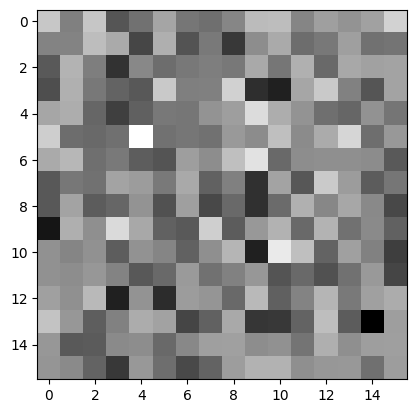

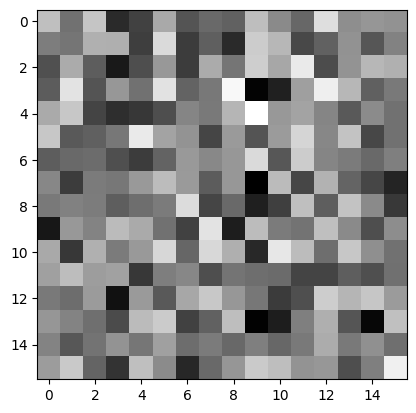

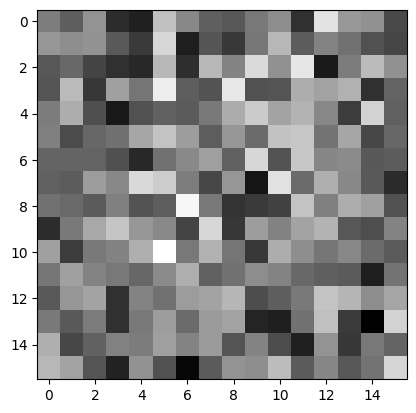

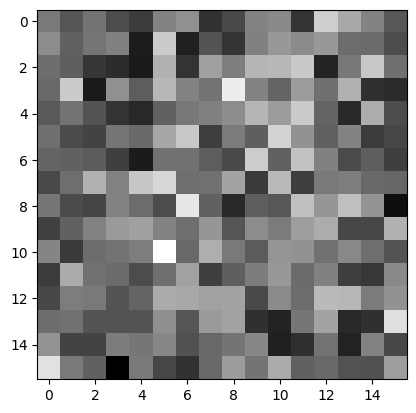

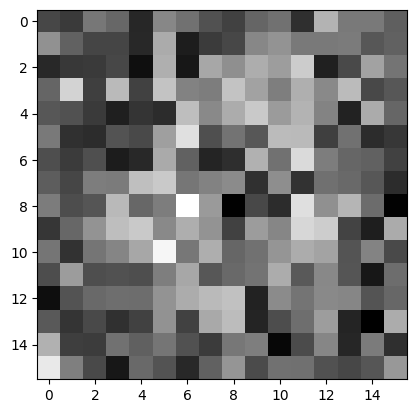

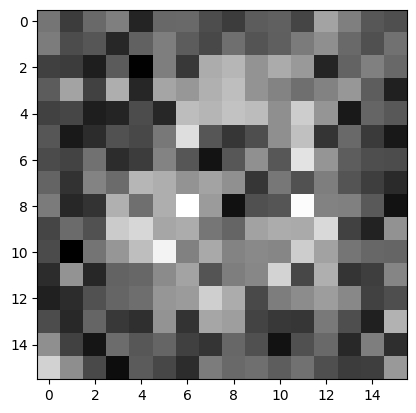

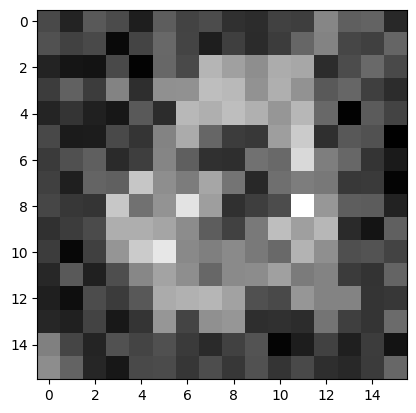

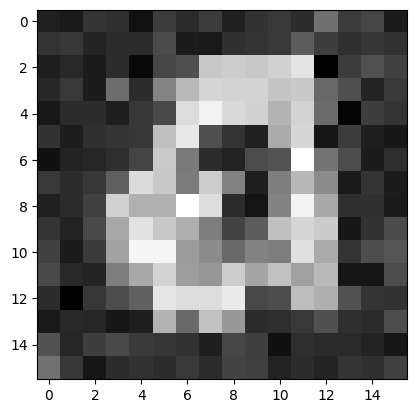

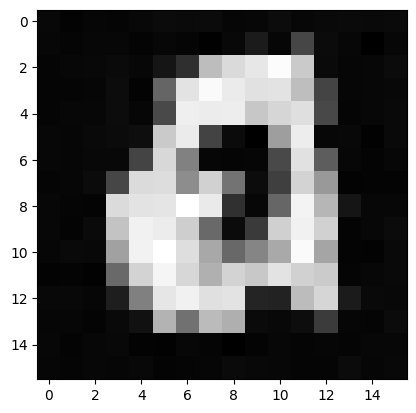

In [58]:
# Generate Gaussian noise
x = random.normal(random.PRNGKey(0), (1, 16, 16, 1))

# Create a list to store output images
img_list_ddpm = []

# Append the initial noise to the list of images
img_list_ddpm.append(jnp.squeeze(jnp.squeeze(x, 0),-1))

# Iterate over T timesteps
for i in tqdm(range(0, timesteps - 1)):
  # t-th timestep
  t = jnp.expand_dims(jnp.array(timesteps - i - 1, jnp.int32), 0)

  # Predict noise using U-Net
  pred_noise = model.apply({'params': trained_state.params}, [x, t])

  # Obtain the output from the noise using the formula seen before
  x = backward_denoising_ddpm(x, pred_noise, t, alpha, alpha_bar)

  # Log the image after every 25 iterations
  if i % 25 == 0:
    img_list_ddpm.append(jnp.squeeze(jnp.squeeze(x, 0),-1))
    plt.imshow(jnp.squeeze(jnp.squeeze(x, 0),-1), cmap='gray')
    plt.show()

### 📝Intermediate


Improving the Inference Process with DDIMs

A major problem with the inference process above is that although we train with an  $x_t$ to predict $x_0$ we have to iterate over all $T$ steps for inference. This can take over a day to generate 50,000, 32×32 images.



  0%|          | 0/10 [00:00<?, ?it/s]

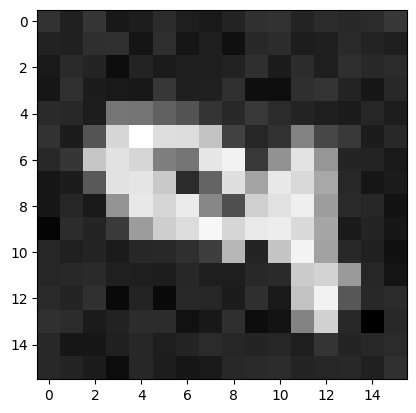

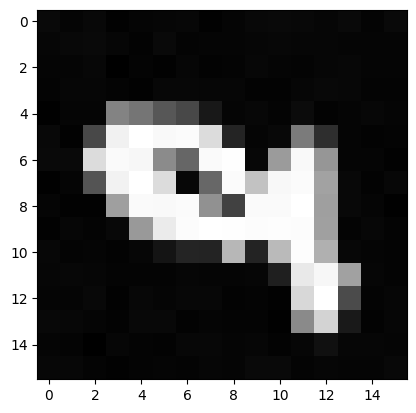

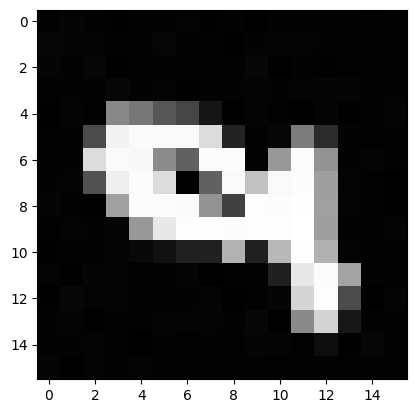

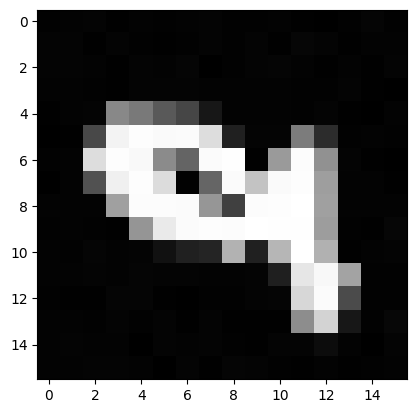

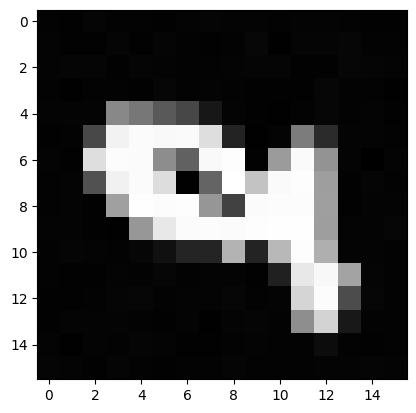

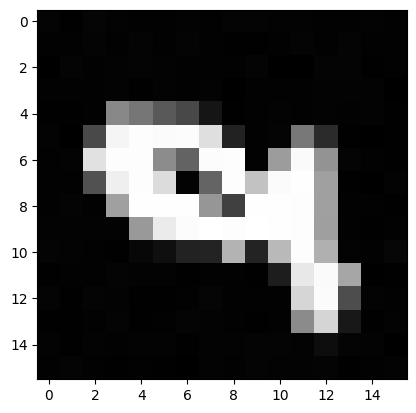

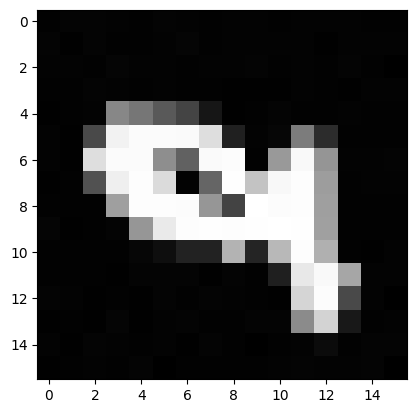

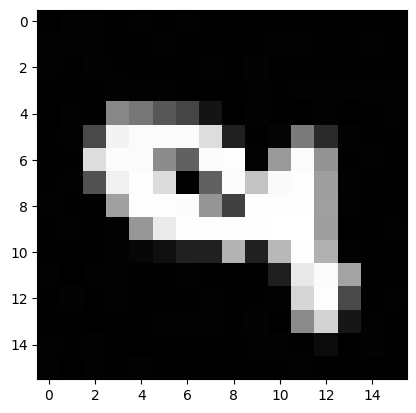

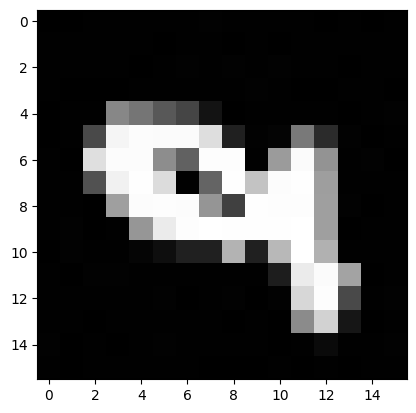

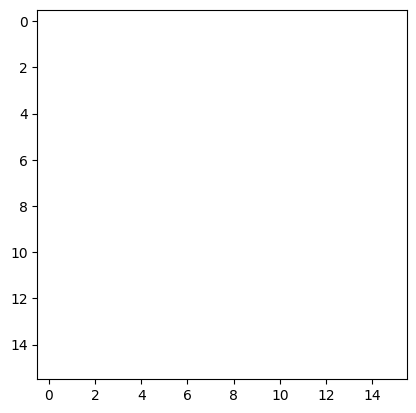

In [62]:
# Get the trained parameters from the trained state
params = trained_state.params

# Generate Gaussian noise
x = random.normal(random.PRNGKey(0), (1, 16, 16, 1))

# Define the number of inference steps and the range of timesteps for inference
inference_timesteps = 10
inference_range = range(0, timesteps, timesteps // inference_timesteps)

# Set steering coefficient
_STEERING_VALUE = 0.9

# Begin the backward noise process
for index, i in tqdm(enumerate(reversed(range(inference_timesteps))), total=inference_timesteps):
    # Fetch the current timestep for inference
    t = jnp.expand_dims(inference_range[i], 0)

    # Predict the noise using the model's apply function
    predicted_noise = model.apply({'params': params}, [x, t])

    # Obtain the output from the noise using the backward process formula
    x = backward_denoising_ddpm(x, predicted_noise, t, alpha, alpha_bar)

    ## IMPLEMENT
    # Implement steering from averaging between the predicted sample and target.
    x = x * (1-_STEERING_VALUE) + _STEERING_VALUE * sample_mnist

    # Display the intermediate image during the backward process
    plt.imshow(jnp.squeeze(jnp.squeeze(x, 0), -1), cmap='gray')
    plt.show()

### 🔎Analysis

**1. How steering improves inference?**

Your answer:

---